In [1]:
import sys
sys.path.append('/home/sajjad/Projects/ChurnApp')

In [2]:
from src.utils import *

from plot_tools import (
    plot_distribution, 
    plot_aggregated_by_time, 
    categorize,
    plot_analysis_of_loan_recovery,
    plot_tops,
    categorize_time_difference,
    save_fig
)

In [3]:
spark = create_spark_session("Plots")
config = load_config("../config.json")
month = get_config_value(config, "months")[0]

24/09/23 19:38:47 WARN Utils: Your hostname, sajjad-Legion-5-15ACH6 resolves to a loopback address: 127.0.1.1; using 172.20.176.90 instead (on interface wlp4s0)
24/09/23 19:38:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/23 19:38:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2024-09-23 19:38:49 - src.utils - INFO - Spark session created for app: Plots
2024-09-23 19:38:49 - src.utils - INFO - Successfully loaded configuration from ../config.json
2024-09-23 19:38:49 - src.utils - INFO - Successfully retrieved config value for keys: ('months',)


# assign

In [4]:
assign = read_parquet(spark=spark, parquet_path=f"../data/raw/parquet/loan_assign_{month}.parquet")
assign.show()

2024-09-23 19:38:51 - src.utils - INFO - Attempting to read Parquet file from: ../data/raw/parquet/loan_assign_38.parquet


2024-09-23 19:38:53 - src.utils - INFO - Successfully read Parquet file from: ../data/raw/parquet/loan_assign_38.parquet
+--------------------+----------+--------------------+--------------------+---------------+-----------+-------------------+
|              bib_id|  date_key|             fake_id|            nid_hash|        loan_id|loan_amount|     date_timestamp|
+--------------------+----------+--------------------+--------------------+---------------+-----------+-------------------+
|3E6BA06831BAC209C...|2024-04-25| f-9801-000118584098|C586E624BABF2B9E1...|404253777958113|    10000.0|2024-04-25 19:22:06|
|189B2E912EF735767...|2024-05-13|f-9801-4800001407...|4F0C1A7FBA96A0666...|405133833577214|    10000.0|2024-05-13 22:21:16|
|4D696C26EBAD024FF...|2024-05-20| f-9801-000145513635|4D7B858855D909521...|405203854905914|    10000.0|2024-05-20 20:25:22|
|FBBB0B6F6C2489B2C...|2024-05-17| f-9801-000134293069|6534A2D9B98F48EAB...|405173845637126|     5000.0|2024-05-17 22:33:25|
|C94E7C58BA

In [5]:
assign = categorize(
df=assign, 
col_name="loan_amount",
bins=[float('-inf'), 5000, 10000, 20000, 50000, 100000, float('inf')],
labels=["VeryLow", "5T-10T", "10T-20T", "20T-50T", "50T-100T", "Extreme"],
new_column_name="loan_category"
)

plot_distribution(df=assign, plot_type='count', month=month, x="loan_category")


Figure saved to: output/CountPlot_of_loan_category__month_38.png


In [6]:
from pyspark.sql.functions import col, sum

aggregated_nid = assign.groupBy("nid_hash").agg(sum(col("loan_amount")).alias("SumAggregated_loan_amount_by_nid"))
plot_distribution(df=aggregated_nid.select("SumAggregated_loan_amount_by_nid"), plot_type='hist', month=month, x="SumAggregated_loan_amount_by_nid")

Figure saved to: output/HistPlot_of_SumAggregated_loan_amount_by_nid__month_38.png


In [7]:
plot_aggregated_by_time(df=assign, timestamp_column="date_timestamp", agg_col="loan_amount", month=month)

Figure saved to: output/LinePlot_of_SumAggregated_loan_amount_by_Hour__month_38.png
Figure saved to: output/LinePlot_of_SumAggregated_loan_amount_by_DayOfWeek__month_38.png
Figure saved to: output/LinePlot_of_SumAggregated_loan_amount_by_DayOfMonth__month_38.png


# recovery

In [10]:
recovery = read_parquet(spark=spark, parquet_path=f"../data/raw/parquet/loan_recovery_{month}.parquet")
recovery.show()

2024-09-23 19:49:50 - src.utils - INFO - Attempting to read Parquet file from: ../data/raw/parquet/loan_recovery_38.parquet
2024-09-23 19:49:50 - src.utils - INFO - Successfully read Parquet file from: ../data/raw/parquet/loan_recovery_38.parquet
+--------------------+----------+--------------------+--------------------+---------------+-----------+-------------+-------------------+
|              bib_id|  date_key|             fake_id|            nid_hash|        loan_id|loan_amount|hsdp_recovery|     date_timestamp|
+--------------------+----------+--------------------+--------------------+---------------+-----------+-------------+-------------------+
|726655A3EBFDB15AD...|2024-05-05| f-9801-000128588413|AEFABE2A3C4E36954...|405043805446600|    10000.0|       6182.0|2024-05-05 17:55:39|
|41E2536B88330EEBF...|2024-04-26| f-9801-000158047302|53588F4DECA562A82...|404253777381174|   100000.0|      80000.0|2024-04-26 17:19:53|
|29AAFA6FB5A867B75...|2024-04-26| f-9801-000152658905|79E733A4A

In [11]:
plot_analysis_of_loan_recovery(assign=assign, recovery=recovery)

Figure saved to: output/Comparison of Recovered and Assigned Loan Amounts --- 82.00% of loan_amounts are recovered.png


# package

In [13]:
package = read_parquet(spark=spark, parquet_path=f"../data/raw/parquet/package_{month}.parquet")
package.show()

2024-09-23 19:51:36 - src.utils - INFO - Attempting to read Parquet file from: ../data/raw/parquet/package_38.parquet
2024-09-23 19:51:36 - src.utils - INFO - Successfully read Parquet file from: ../data/raw/parquet/package_38.parquet
+--------------------+----------+--------------------+--------------------+-------------+------------+--------------------+-------------------+-------------------+
|              bib_id|  date_key|             fake_id|            nid_hash|offering_code|offer_amount|       offering_name|    activation_date|  deactivation_date|
+--------------------+----------+--------------------+--------------------+-------------+------------+--------------------+-------------------+-------------------+
|3CC6F1606EA449905...|2024-04-27| f-9801-000086491524|D8FBDE325D0503508...|    PO2025XOI|    155000.0|      15 Days 1 5 GB|2024-04-27 12:24:18|2024-05-12 23:59:59|
|EAAF83DD232522F30...|2024-04-23|f-9801-3950002593...|1E24BBB952A5D185F...|    PO2106HBH|    485000.0|       

In [14]:
diff = categorize_time_difference(df=package)
diff.show()

+--------------------+----------+--------------------+--------------------+-------------+------------+--------------------+-------------------+-------------------+--------------------+-----------------+
|              bib_id|  date_key|             fake_id|            nid_hash|offering_code|offer_amount|       offering_name|    activation_date|  deactivation_date|time_difference_days|duration_category|
+--------------------+----------+--------------------+--------------------+-------------+------------+--------------------+-------------------+-------------------+--------------------+-----------------+
|3CC6F1606EA449905...|2024-04-27| f-9801-000086491524|D8FBDE325D0503508...|    PO2025XOI|    155000.0|      15 Days 1 5 GB|2024-04-27 12:24:18|2024-05-12 23:59:59|                  15|     Half-Monthly|
|EAAF83DD232522F30...|2024-04-23|f-9801-3950002593...|1E24BBB952A5D185F...|    PO2106HBH|    485000.0|         60Days 10GB|2024-04-23 20:00:51|2024-06-22 23:59:59|                  60|    

In [15]:
plot_tops(diff, col_name="duration_category", index=10, month=month)

Figure saved to: output/top_10_popular_duration_categorys__month_38.png


In [16]:
plot_tops(df=package, col_name="offering_name", index=25, month=month)

Figure saved to: output/top_25_popular_offering_names__month_38.png


# recharge

In [17]:
recharge = read_parquet(spark=spark, parquet_path=f"../data/raw/parquet/recharge_{month}.parquet")
recharge.show()

2024-09-23 19:52:42 - src.utils - INFO - Attempting to read Parquet file from: ../data/raw/parquet/recharge_38.parquet
2024-09-23 19:52:42 - src.utils - INFO - Successfully read Parquet file from: ../data/raw/parquet/recharge_38.parquet
+--------------------+----------+--------------------+--------------------+------------------+-------------------+--------------+--------------------------+-------------------------+
|              bib_id|  date_key|             fake_id|            nid_hash|recharge_value_amt|        recharge_dt|origin_host_nm|account_balance_before_amt|account_balance_after_amt|
+--------------------+----------+--------------------+--------------------+------------------+-------------------+--------------+--------------------------+-------------------------+
|6691FBCA0320E1410...|2024-04-24| f-9801-000133407354|CC910C691906145A3...|           10000.0|2024-04-24 18:24:09|    MFSEREFILL|                    4742.0|                  14742.0|
|6691FBCA0320E1410...|2024-05-0

In [18]:
recharge = categorize(
    df=recharge, 
    col_name="recharge_value_amt", 
    bins=[float('-inf'), 10000, 20000, 50000, 100000, 200000, 500000, float('inf')],
    labels=["1T", "2T", "5T", "10T", "20T", "50T", "More"],
    new_column_name="recharge_category"
)

plot_distribution(df=recharge.select("recharge_category"), plot_type='count', month=month, x="recharge_category")

Figure saved to: output/CountPlot_of_recharge_category__month_38.png


In [19]:
plot_aggregated_by_time(df=recharge, timestamp_column="recharge_dt", agg_col="recharge_value_amt", month=month )

Figure saved to: output/LinePlot_of_SumAggregated_recharge_value_amt_by_Hour__month_38.png
Figure saved to: output/LinePlot_of_SumAggregated_recharge_value_amt_by_DayOfWeek__month_38.png
Figure saved to: output/LinePlot_of_SumAggregated_recharge_value_amt_by_DayOfMonth__month_38.png


# user

In [20]:
user = read_parquet(spark=spark, parquet_path=f"../data/raw/parquet/user_{month}.parquet")
user.show()

2024-09-23 19:54:03 - src.utils - INFO - Attempting to read Parquet file from: ../data/raw/parquet/user_38.parquet
2024-09-23 19:54:03 - src.utils - INFO - Successfully read Parquet file from: ../data/raw/parquet/user_38.parquet
+--------------------+--------------------+--------------------+---------------+--------+-------------------+---------------+--------------+---------------+---------------+-----+
|              bib_id|             fake_id|            nid_hash|contract_type_v|gender_v|registration_date_d|date_of_birth_d|ability_status|account_balance|base_station_cd|sitei|
+--------------------+--------------------+--------------------+---------------+--------+-------------------+---------------+--------------+---------------+---------------+-----+
|49E6FDF4EEB2E89FC...| f-9801-000085090724|8A06499703399382F...|              P|       F|         2016-12-03|     1995-06-20|        Active|   27966.666667|      LE1153XA5|E1153|
|2702ED39052AF2D9F...| f-9801-000125775769|4F3B4EF23B78

<Axes: ylabel='count'>

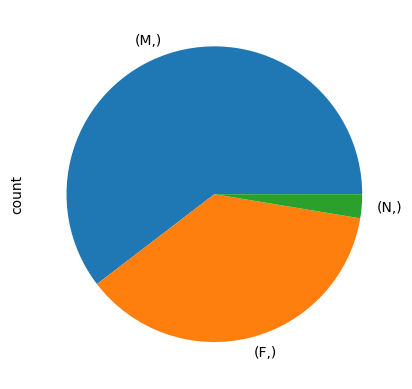

In [22]:
user.select("gender_v").toPandas().value_counts().plot(kind="pie")